In [112]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Obtenemos los datos

In [34]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [35]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
train.shape # Vemos la cantidad de filas y columnas

(1460, 81)

# ETL

In [36]:
# Obtenemos las columnas que tiene mas del 80 % de nulos
def columnas_nulos(dataframe):

    train_columns = dataframe.columns

    columnas = [col for col in train_columns if dataframe[col].isna().sum() > 650 ]

    return columnas

In [37]:
# Obtenemos las columnas que tiene mas del 80 % de CEROS
def columnas_ceros(dataframe):

    train_columns = dataframe.columns

    columnas = [col for col in train_columns if (dataframe[col]==0).sum() > 650 ]

    return columnas

In [39]:
drop_col = columnas_nulos(train) # lista de columnas que tienen mas de 650 nulos
drop_col.extend(columnas_ceros(train)) # lista de las columnas que tienen mas de 650 ceros 

# Eliminamos las columnas que tienen el 80% de nulos y ceros
train.drop(columns=drop_col,inplace=True)



In [10]:
# checamos si hay ID's repetidos
train['Id'].duplicated().sum()

0

In [40]:
train_numeric = train.select_dtypes(include=['int','float'])

In [41]:
train_numeric.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [42]:
train_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,...,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,706,150,...,2,3,1,8,2003.0,2,548,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,978,284,...,2,3,1,6,1976.0,2,460,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,486,434,...,2,3,1,6,2001.0,2,608,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,216,540,...,1,3,1,7,1998.0,3,642,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,655,490,...,2,4,1,9,2000.0,3,836,12,2008,250000


In [43]:
# Contar ceros en cada columna
conteo_ceros = (train_numeric == 0).sum()
conteo_ceros

Id                0
MSSubClass        0
LotFrontage       0
LotArea           0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
BsmtFinSF1      467
BsmtUnfSF       118
TotalBsmtSF      37
1stFlrSF          0
GrLivArea         0
FullBath          9
BedroomAbvGr      6
KitchenAbvGr      1
TotRmsAbvGrd      0
GarageYrBlt       0
GarageCars       81
GarageArea       81
MoSold            0
YrSold            0
SalePrice         0
dtype: int64

In [ ]:
train_numeric.columns

# Obtenemos las columnas no numericas y aplicamos one hot encoding para pasar a numericos 

In [44]:
train_object = train.select_dtypes(include=['object'])

In [45]:
train_object.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [46]:
train_object['Sales'] = train_numeric['SalePrice']

In [47]:
from sklearn.model_selection import KFold

In [48]:
# Columnas que usaran K-Fold Target Encoding
lista_tarEncoding = ["MSZoning", "Utilities", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",  "Foundation", "BsmtFinType1", "Heating", "Electrical", "Functional", "GarageType", "SaleType", "SaleCondition"]

In [51]:
col = columnas_ceros(train_object[lista_tarEncoding]) # Funcion para conocer si hay columnas con mas de 650 nulos
col

[]

In [52]:
len(lista_tarEncoding)

19

In [53]:
# Numero de pliegues (folds)
n_splits = 3
kf = KFold(n_splits=n_splits,shuffle=True,random_state=42)

In [54]:
# Crear un nuevo DataFrame para almacenar las columnas codificadas
train_object_encoded = train_object[lista_tarEncoding].copy()

In [55]:
train_object_encoded.columns

Index(['MSZoning', 'Utilities', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'Foundation', 'BsmtFinType1', 'Heating', 'Electrical',
       'Functional', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

In [56]:
# FUncion para aplicar K-Fold Trget Encoding a una columna categorica

def kfold_target_encoding (df,column , target,kf):
    encoded_column = np.zeros(len(df))

    for train_idx , val_idx in kf.split(df):
        train_data , val_data = df.iloc[train_idx],df.iloc[val_idx]


        #Calcula la media de la variable objetivo por categoria en el conjunto de entrenamiento

        target_means = train_data.groupby(column)[target].mean()

        # Asignar la media al conjunto de validación
        encoded_column[val_idx] = val_data[column].map(target_means)
    
    return encoded_column



In [57]:
# Aplicar K-Fold Target Encoding a todas las columnas categóricas
for column in lista_tarEncoding:
    encoded_col_name = f"{column}_encoded"
    train_object_encoded[encoded_col_name] = kfold_target_encoding(train_object, column, 'Sales', kf)


In [58]:
train_object_encoded.columns

Index(['MSZoning', 'Utilities', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'Foundation', 'BsmtFinType1', 'Heating', 'Electrical',
       'Functional', 'GarageType', 'SaleType', 'SaleCondition',
       'MSZoning_encoded', 'Utilities_encoded', 'Neighborhood_encoded',
       'Condition1_encoded', 'Condition2_encoded', 'BldgType_encoded',
       'HouseStyle_encoded', 'RoofStyle_encoded', 'RoofMatl_encoded',
       'Exterior1st_encoded', 'Exterior2nd_encoded', 'Foundation_encoded',
       'BsmtFinType1_encoded', 'Heating_encoded', 'Electrical_encoded',
       'Functional_encoded', 'GarageType_encoded', 'SaleType_encoded',
       'SaleCondition_encoded'],
      dtype='object')

In [59]:
len(train_object_encoded.columns.tolist())

38

In [60]:
train_object_encoded.drop(columns=lista_tarEncoding, inplace=True , axis=1) # Borramos las columnas originales

In [61]:
train_object_encoded.head()

,MSZoning_encoded,Utilities_encoded,Neighborhood_encoded,Condition1_encoded,Condition2_encoded,BldgType_encoded,HouseStyle_encoded,RoofStyle_encoded,RoofMatl_encoded,Exterior1st_encoded,Exterior2nd_encoded,Foundation_encoded,BsmtFinType1_encoded,Heating_encoded,Electrical_encoded,Functional_encoded,GarageType_encoded,SaleType_encoded,SaleCondition_encoded
0,190075.623711,180286.591984,195712.000000,183242.180851,180432.519710,185298.67750,210728.861592,171267.445910,179099.565762,213023.426829,214220.062696,224471.147887,234123.513011,180991.692872,185916.272523,182790.726269,201781.720971,173117.712085,174602.518285
1,191586.845347,181410.191161,226333.333333,139504.301887,181820.546778,185839.87846,174963.073375,171264.509753,179992.259958,148083.044118,148602.177778,148408.338095,160823.784722,182905.788038,187897.689539,183931.185510,203969.925676,173307.550535,175560.167910
2,190075.623711,180286.591984,195712.000000,183242.180851,180432.519710,185298.67750,210728.861592,171267.445910,179099.565762,213023.426829,214220.062696,224471.147887,234123.513011,180991.692872,185916.272523,182790.726269,201781.720971,173117.712085,174602.518285
3,190075.623711,180286.591984,215912.848485,183242.180851,180432.519710,185298.67750,210728.861592,171267.445910,179099.565762,152460.449275,169540.740741,133268.924731,162641.833333,180991.692872,185916.272523,182790.726269,133615.558052,173117.712085,148066.716216
4,191586.845347,181410.191161,350294.740741,185221.861244,181820.546778,185839.87846,214223.744966,171264.509753,179992.259958,215945.862464,215872.401163,228354.697941,239839.000000,182905.788038,187897.689539,183931.185510,203969.925676,173307.550535,175560.167910


In [62]:
train_object_encoded.shape

(1460, 19)

# Conversion de datos con Ordinal Encoding

In [63]:
from sklearn.preprocessing import OrdinalEncoder

In [64]:
# Lista de las categorias a transformar con Ordinal Encoding
lista_OrEncoding = ["LotShape", "LandSlope", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "GarageFinish", "GarageQual", "GarageCond", ]

In [65]:
col_ordinal = columnas_nulos(train_object[lista_OrEncoding]) # Verificar si las columnas tienen muchos nulos
col_ordinal

[]

In [35]:
len(lista_OrEncoding)

14

In [66]:
# Crear el codificador ordinal instanciamos un objeto de OrdinalEncoder()
encoder = OrdinalEncoder()

In [67]:
# Hacemos una copia con las columnas que aplica el Ordinal Encoding
df_ordinalEncoding = train_object[lista_OrEncoding].copy()

In [68]:
df_ordinalEncoding.columns

Index(['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')

In [69]:
# Aplicar el Ordinal Encoding a las columnas categóricas
df_ordinalEncoding[lista_OrEncoding] = encoder.fit_transform(df_ordinalEncoding[lista_OrEncoding])


In [70]:
df_ordinalEncoding.head()

,LotShape,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,GarageFinish,GarageQual,GarageCond
0,3.0,0.0,2.0,4.0,2.0,3.0,3.0,2.0,5.0,0.0,2.0,1.0,4.0,4.0
1,3.0,0.0,3.0,4.0,2.0,3.0,1.0,0.0,5.0,0.0,3.0,1.0,4.0,4.0
2,0.0,0.0,2.0,4.0,2.0,3.0,2.0,2.0,5.0,0.0,2.0,1.0,4.0,4.0
3,0.0,0.0,3.0,4.0,3.0,1.0,3.0,0.0,5.0,2.0,2.0,2.0,4.0,4.0
4,0.0,0.0,2.0,4.0,2.0,3.0,0.0,2.0,5.0,0.0,2.0,1.0,4.0,4.0


### Ahora juntamos los data frames df_ordinalEncoding y train_object_encoded

In [71]:
df_NoNumeric = pd.concat([df_ordinalEncoding,train_object_encoded],axis=1)

In [72]:
df_NoNumeric.columns

Index(['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond',
       'MSZoning_encoded', 'Utilities_encoded', 'Neighborhood_encoded',
       'Condition1_encoded', 'Condition2_encoded', 'BldgType_encoded',
       'HouseStyle_encoded', 'RoofStyle_encoded', 'RoofMatl_encoded',
       'Exterior1st_encoded', 'Exterior2nd_encoded', 'Foundation_encoded',
       'BsmtFinType1_encoded', 'Heating_encoded', 'Electrical_encoded',
       'Functional_encoded', 'GarageType_encoded', 'SaleType_encoded',
       'SaleCondition_encoded'],
      dtype='object')

In [40]:
df_NoNumeric.shape

(1460, 33)

### Principales caracteridticas numericas
- OverallQual    0.158115
-    GrLivArea    0.127988
-    GarageCars    0.109632
-    GarageArea    0.072814
-      YearBuilt    0.065051
-      1stFlrSF    0.061446
-   TotalBsmtSF    0.061166
-   GarageYrBlt    0.043131
-   YearRemodAdd    0.034575
-     BsmtFinSF1    0.033037
-        LotArea    0.030589



### Principales caracteristicas data no numerica
- Neighborhood_encoded    0.153572
-               ExterQual    0.119141
-               BsmtQual    0.095820
-           KitchenQual    0.089220
-           GarageFinish    0.060542
-     GarageType_encoded    0.051263
-     Foundation_encoded    0.044446
-    Exterior1st_encoded    0.034598
-   BsmtFinType1_encoded    0.034059
-    Exterior2nd_encoded    0.031655

In [ ]:
###

## EDA

## Grafica de la distribucion de precios de las casas por año construido

In [43]:
# Crear una columna para los rangos
train_numeric['rango'] = pd.cut(train_numeric['SalePrice'], bins=[0, 100000, 200000, 300000,400000,500000,600000,700000], labels=['1', '2', '3','4','5','6','7'])




In [50]:
train_numeric.sort_values(by='SalePrice')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice,rango
495,496,30,60.0,7879,4,5,1920,1950,0.0,495,...,0,NaN,0,0,0,523,11,2009,34900,1
916,917,20,50.0,9000,2,3,1949,1950,0.0,50,...,0,1958.0,1,308,0,0,10,2006,35311,1
968,969,50,50.0,5925,3,6,1910,1950,0.0,0,...,0,NaN,0,0,0,0,5,2009,37900,1
533,534,20,50.0,5000,1,3,1946,1950,0.0,0,...,0,NaN,0,0,0,0,1,2007,39300,1
30,31,70,50.0,8500,4,4,1920,1950,0.0,0,...,0,1920.0,1,250,0,54,7,2008,40000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,804,60,107.0,13891,9,5,2008,2009,424.0,0,...,1,2009.0,3,1020,52,170,1,2009,582933,6
898,899,20,100.0,12919,9,5,2009,2010,760.0,2188,...,2,2009.0,3,820,0,67,3,2010,611657,7
1169,1170,60,118.0,35760,10,5,1995,1996,1378.0,1387,...,1,1995.0,3,807,361,76,7,2006,625000,7
1182,1183,60,160.0,15623,10,5,1996,1996,0.0,2096,...,2,1996.0,3,813,171,78,7,2007,745000,NaN


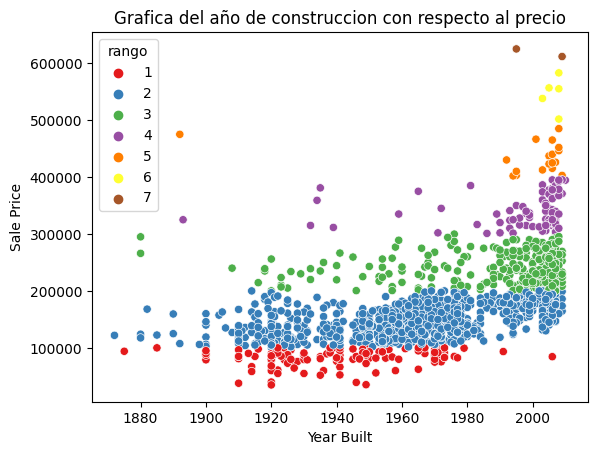

In [48]:
sns.scatterplot(x='YearBuilt',y='SalePrice',data=train_numeric,hue='rango', palette='Set1')
plt.title("Grafica del año de construccion con respecto al precio")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.show()

In [45]:
# Crear grupos de años en 6 categorías (bins)
train_numeric["grupo_anio"] = pd.cut(train_numeric["YearBuilt"], bins=6, labels=["1872-1895", "1896-1919", "1920-1943", "1944-1966", "1967-1990", "1991-2010"])

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


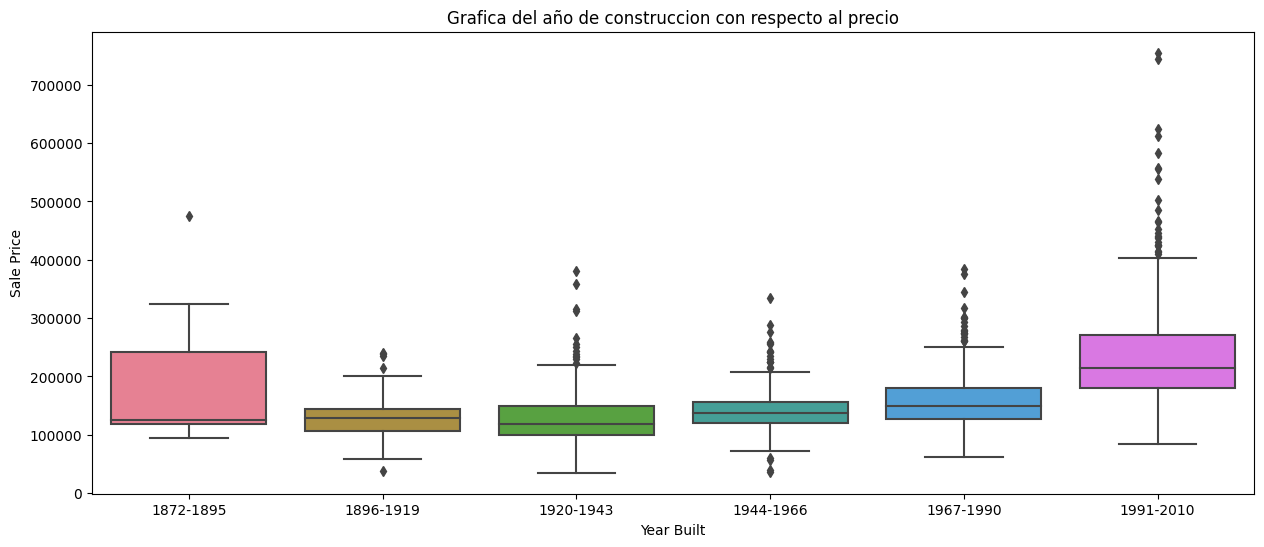

In [47]:
# Crear el boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(data=train_numeric , x="grupo_anio", y="SalePrice" , palette="husl")
plt.title("Grafica del año de construccion con respecto al precio")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.show()

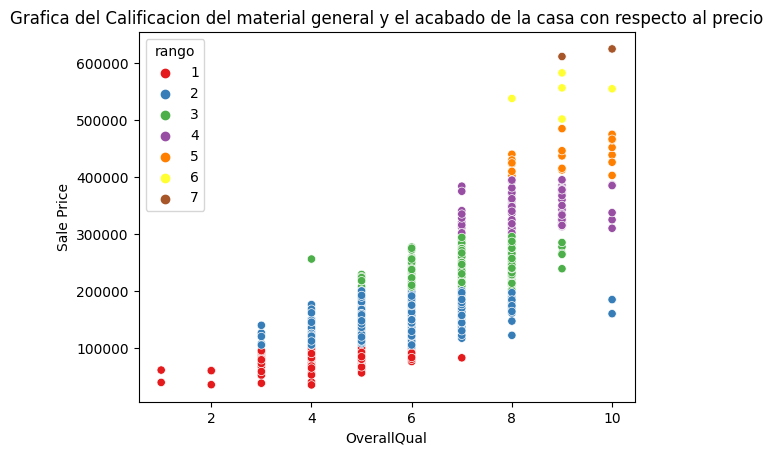

In [52]:
sns.scatterplot(x='OverallQual',y='SalePrice',data=train_numeric,hue='rango', palette='Set1')
plt.title("Grafica del Calificacion del material general y el acabado de la casa con respecto al precio")
plt.xlabel("OverallQual")
plt.ylabel("Sale Price")
plt.show()

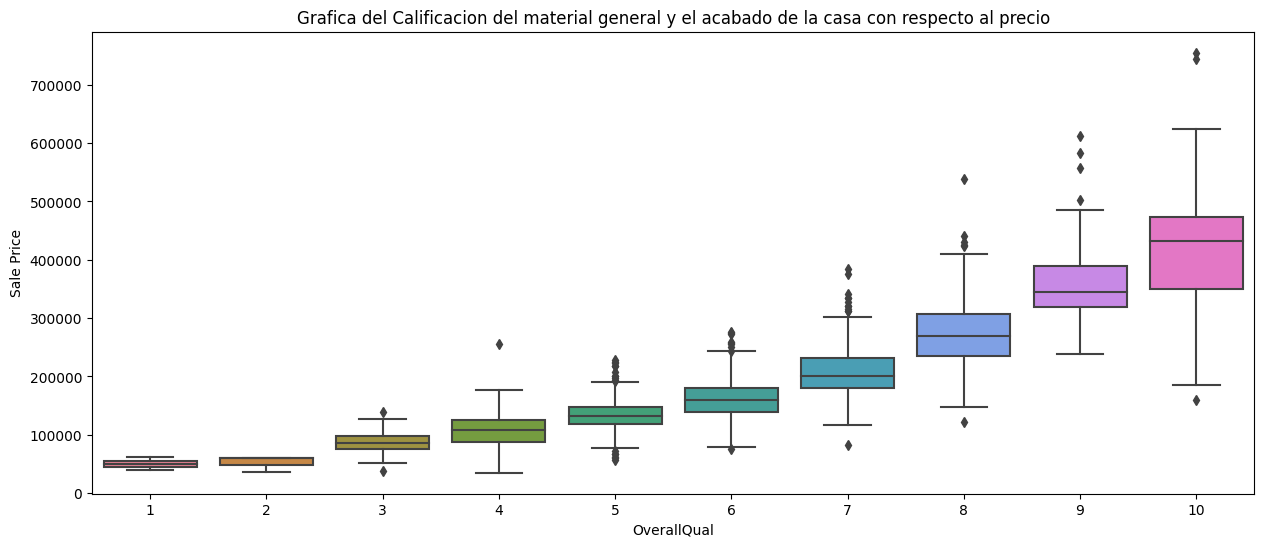

In [55]:
# Crear el boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(data=train_numeric , x="OverallQual", y="SalePrice" , palette="husl")
plt.title("Grafica del Calificacion del material general y el acabado de la casa con respecto al precio")
plt.xlabel("OverallQual")
plt.ylabel("Sale Price")
plt.show()

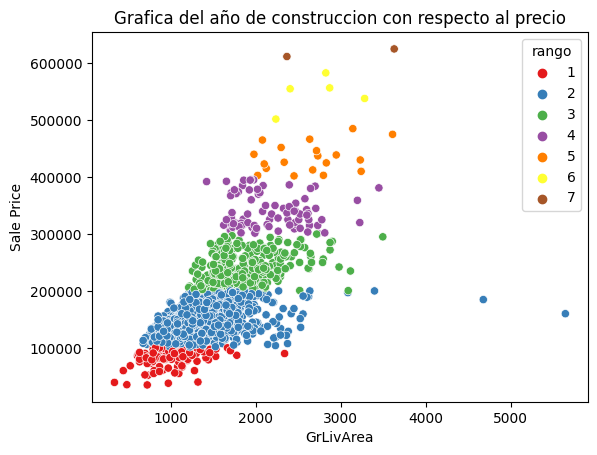

In [53]:
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train_numeric,hue='rango', palette='Set1')
plt.title("Grafica del año de construccion con respecto al precio")
plt.xlabel("GrLivArea")
plt.ylabel("Sale Price")
plt.show()

In [56]:
train_numeric["GrLivArea"].sort_values()

533      334
1100     438
916      480
29       520
528      605
        ... 
1169    3627
691     4316
1182    4476
523     4676
1298    5642
Name: GrLivArea, Length: 1460, dtype: int64

In [57]:
# Crear grupos de años en 6 categorías (bins)
train_numeric["grupo_GrLivArea"] = pd.cut(train_numeric["GrLivArea"], bins=6, labels=["1000", "2000", "3000", "4000", "5000", "6000"])

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


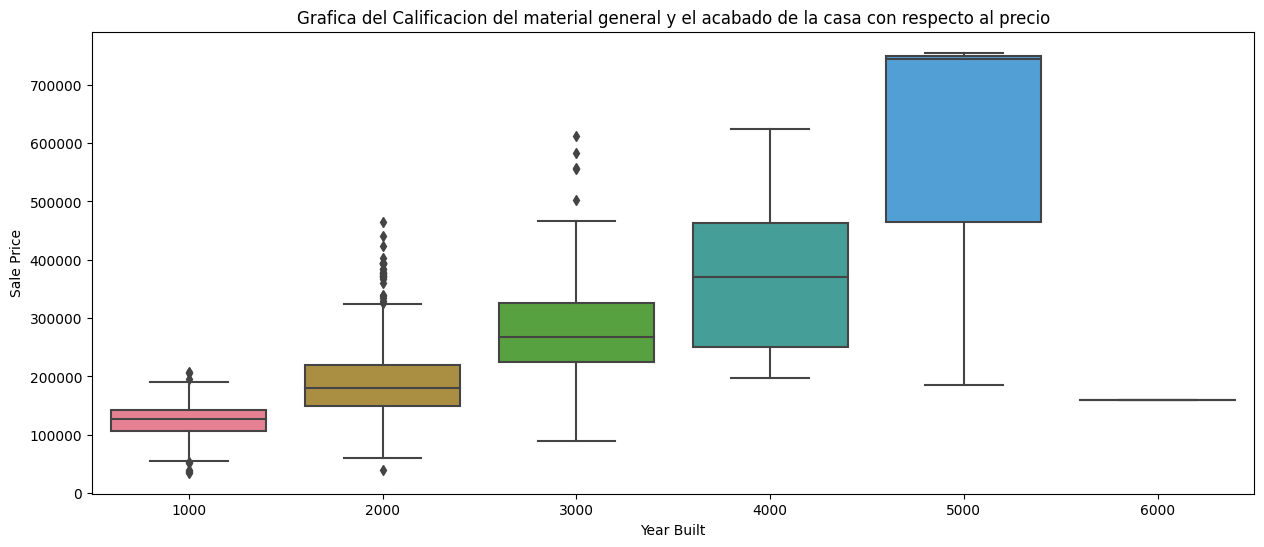

In [58]:
# Crear el boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(data=train_numeric , x="grupo_GrLivArea", y="SalePrice" , palette="husl")
plt.title("Grafica del Calificacion del material general y el acabado de la casa con respecto al precio")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.show()

## Grafica de la distribucion del precio de las casa por area

In [ ]:
# Crear una columna para los rangos
train['rango'] = pd.cut(train['SalePrice'], bins=[0, 100000, 200000, 300000,400000,500000,600000,700000], labels=['1', '2', '3','4','5','6','7'])




In [ ]:
sns.scatterplot(x='LotArea',y='SalePrice',data=train_numeric,hue='rango', palette='Set1')
plt.show()

## Grafica de precios de hogares por total de habitaciones

In [ ]:
sns.scatterplot(x='TotRmsAbvGrd',y='SalePrice',data=train_numeric,hue='rango', palette='Set1')
plt.show()

## Grafica del numero de hogares por precio

In [ ]:

sns.countplot(data=train_numeric, x='rango', palette='viridis')
plt.xlabel('rango')
plt.ylabel('Numero de casas')
plt.show()

## Grafica numero de hogares por zona

In [ ]:

sns.countplot(data=train, x='MSZoning', palette='viridis')
plt.xlabel('Tipo de zona')
plt.ylabel('Numero de casas')
plt.show()

## Grafica de precios segun la zona

- A	Agriculture

- C	Commercial

- FV	Floating Village Residential

- I	Industrial

- RH	Residential High Density

- RL	Residential Low Density

- RP	Residential Low Density Park 

- RM	Residential Medium Density


In [ ]:
sns.scatterplot(x='MSZoning',y='SalePrice',data=train,hue='rango', palette='Set1')
plt.show()

## Grafica de los precios segun las condiciones alrededor

- Artery	Adjacent to arterial street
- Feedr	Adjacent to feeder street	
- Norm	Normal	
- RRNn	Within 200' of North-South Railroad
- RRAn	Adjacent to North-South Railroad
- PosN	Near positive off-site feature--park, greenbelt, etc.
- PosA	Adjacent to postive off-site feature
- RRNe	Within 200' of East-West Railroad
- RRAe	Adjacent to East-West Railroad

In [ ]:
sns.scatterplot(x='Condition1',y='SalePrice',data=train,hue='rango', palette='Set1')
plt.show()

## Grafica de precios de lascasas segunel tipode vivienda

- 1Fam	Single-family Detached	
- 2FmCon	Two-family Conversion; originally built as one-family dwelling
- Duplx	Duplex
- TwnhsE	Townhouse End Unit
- TwnhsI	Townhouse Inside Unit

In [ ]:
sns.scatterplot(x='BldgType',y='SalePrice',data=train,hue='rango', palette='Set1')
plt.show()

## Grafica de precios segun el estilo de la casa

- 1Story	One story
- 1.5Fin	One and one-half story: 2nd level finished
- 1.5Unf	One and one-half story: 2nd level unfinished
- 2Story	Two story
- 2.5Fin	Two and one-half story: 2nd level finished
- 2.5Unf	Two and one-half story: 2nd level unfinished
- SFoyer	Split Foyer
- SLvl	Split Level

In [ ]:
sns.scatterplot(x='HouseStyle',y='SalePrice',data=train,hue='rango', palette='Set1')
# Mover la leyenda a una posición específica
plt.legend(title='Categoría', loc='upper right')  # Cambiar loc según sea necesario

plt.show()

## Entrenamiento del modelo Random Forest

In [85]:
train_numeric.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [62]:
columnas_train = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold']

In [63]:
X_Numeric = train_numeric[columnas_train]
Y_Numeric = train_numeric['SalePrice']

In [64]:
X_Numeric.isna().sum()

MSSubClass        0
LotFrontage     259
LotArea           0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
MasVnrArea        8
BsmtFinSF1        0
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
1stFlrSF          0
2ndFlrSF          0
GrLivArea         0
BsmtFullBath      0
FullBath          0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
Fireplaces        0
GarageYrBlt      81
GarageCars        0
GarageArea        0
WoodDeckSF        0
OpenPorchSF       0
MoSold            0
YrSold            0
dtype: int64

In [65]:
X_Numeric = X_Numeric.fillna(0)

In [66]:
X_Numeric.isna().sum()

MSSubClass      0
LotFrontage     0
LotArea         0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
BsmtFullBath    0
FullBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageYrBlt     0
GarageCars      0
GarageArea      0
WoodDeckSF      0
OpenPorchSF     0
MoSold          0
YrSold          0
dtype: int64

# Escalamos la data Numerica

In [98]:
#robustScaler

def robustScaler(dataframe):
    Robustscaler = RobustScaler()
    Numeric_scaled = Robustscaler.fit_transform(dataframe)
    dataScaled = pd.DataFrame(Numeric_scaled,columns=dataframe.columns)

    return dataScaled

In [99]:
#StandarScaler

def standarScaler(dataframe):
    scaler = StandardScaler()
    Numeric_scaled = scaler.fit_transform(dataframe)
    dataScaled = pd.DataFrame(Numeric_scaled,columns=dataframe.columns)
    return dataScaled

In [68]:
X_Numeric.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold
0,0.2,0.054054,-0.254076,0.5,0.0,0.652174,0.243243,1.193303,0.452790,0.0,...,0.0,1.0,-1.0,0.604651,0.0,0.281573,0.000000,0.529412,-1.333333,0.0
1,-0.6,0.459459,0.030015,0.0,3.0,0.065217,-0.486486,0.000000,0.834679,0.0,...,0.0,0.0,0.0,-0.023256,0.0,-0.082816,1.773810,-0.367647,-0.333333,-0.5
2,0.2,0.135135,0.437624,0.5,0.0,0.608696,0.216216,0.986301,0.143910,0.0,...,0.0,0.0,0.0,0.558140,0.0,0.530021,0.000000,0.250000,1.000000,0.0
3,0.4,-0.081081,0.017663,0.5,0.0,-1.260870,-0.648649,0.000000,-0.235170,0.0,...,0.0,0.5,0.0,0.488372,1.0,0.670807,0.000000,0.147059,-1.333333,-1.0
4,0.2,0.567568,1.181201,1.0,0.0,0.586957,0.162162,2.130898,0.381186,0.0,...,0.0,1.5,0.0,0.534884,1.0,1.474120,1.142857,0.867647,2.000000,0.0


## Dividimos la data en train y test

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_Numeric, Y_Numeric, test_size=0.2, random_state=42)

In [74]:
# Instanciamos el modelo
random_model = RandomForestRegressor(n_estimators=100, random_state=42,max_features='sqrt',n_jobs=-1,oob_score=True)
random_model.fit(X_train,y_train)

RandomForestRegressor(max_features='sqrt', n_jobs=-1, oob_score=True,
                      random_state=42)

In [109]:
# vemos cuales son las caracteristicas mas rlevantes
# Obtener las importancias de las características
importances = random_model.feature_importances_

# Visualizar las importancias

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Ordena el DataFrame por importancia descendente
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Imprime las características más importantes
print(feature_importances)

         Feature  Importance
3    OverallQual    0.158115
14     GrLivArea    0.127988
22    GarageCars    0.109632
23    GarageArea    0.072814
5      YearBuilt    0.065051
12      1stFlrSF    0.061446
11   TotalBsmtSF    0.061166
21   GarageYrBlt    0.043131
6   YearRemodAdd    0.034575
8     BsmtFinSF1    0.033037
2        LotArea    0.030589
16      FullBath    0.028086
13      2ndFlrSF    0.027563
20    Fireplaces    0.021668
1    LotFrontage    0.017365
19  TotRmsAbvGrd    0.016742
7     MasVnrArea    0.012543
25   OpenPorchSF    0.012059
10     BsmtUnfSF    0.011797
24    WoodDeckSF    0.009770
0     MSSubClass    0.009103
17  BedroomAbvGr    0.008456
4    OverallCond    0.006999
26        MoSold    0.006739
15  BsmtFullBath    0.006264
27        YrSold    0.003383
18  KitchenAbvGr    0.002472
9     BsmtFinSF2    0.001449


In [75]:
# Evaluamos
y_test_pred = random_model.predict(X_test)

In [77]:
#oob_score_ es una estimación del rendimiento del modelo basado en las muestras OOB y puede proporcionar una medida de la precisión del modelo sin necesidad de un conjunto de validación separado.
print(f"OOB Score: {random_model.oob_score_}")

OOB Score: 0.843279699476657


In [78]:

# Calcular métricas
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Mostrar métricas
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.2f}")

MSE: 832916587.66
RMSE: 28860.29
MAE: 17449.96
R^2: 0.89


# Ahora aplicamos el modelo XGBOOST

In [79]:
import xgboost as xgb

In [91]:
# Crear el modelo XGBoost para regresión
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42,reg_lambda=1.0, learning_rate=0.1 )  # Tasa de aprendizaje   # Regularización L2 (parámetro lambda)learning_rate=0.1,         

In [92]:
# Entrenar el modelo
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [93]:
# Realizar predicciones
y_pred_Numeric = model_xgb.predict(X_test)

In [94]:
# Calcular métricas de evaluación
mae = mean_absolute_error(y_test, y_pred_Numeric)
mse = mean_squared_error(y_test, y_pred_Numeric)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_Numeric)

In [95]:
# Mostrar las métricas
print("Métricas de rendimiento del modelo:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Métricas de rendimiento del modelo:
Mean Absolute Error (MAE): 17535.4931
Mean Squared Error (MSE): 733050658.0062
Root Mean Squared Error (RMSE): 27074.9083
R² Score: 0.9044


## Predecimos con el DataFrame de test

In [ ]:
X_Test = test[X_train.columns]
X_Test = X_Test.fillna(0)

In [ ]:
Y_Test_pred = random_model.predict(X_Test)

In [ ]:
test.shape

In [ ]:
len(Y_Test_pred)

# Salida de prediciones

In [ ]:
output = pd.DataFrame({'Id': test.Id, 'SalePrice': Y_Test_pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

## Tratamos de mejorar el modelo RandomForest mejorando sus hiperparametros

In [119]:
from sklearn.model_selection import GridSearchCV

In [120]:
# Definir la rejilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],            # Número de árboles
    'max_depth': [None, 10, 20, 30],          # Profundidad máxima
    'min_samples_split': [2, 5, 10],          # Min muestras para dividir
    'min_samples_leaf': [1, 2, 4],            # Min muestras en una hoja
    'max_features': ['sqrt', 'log2']          # Número de características
}

In [121]:
# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring='neg_mean_squared_error',  # Métrica para evaluar
    n_jobs=-1  # Usar todos los núcleos
)

In [ ]:
#Extraemos las columnas que solo son tipo int
columna_enteras = X_train.select_dtypes(include=['int'])

In [ ]:
# Convertimoslascolumnas de int a float
X_train[columna_enteras.columns] = X_train[columna_enteras.columns].astype(float)

In [ ]:
# Validamos si se convertieron los int a float
X_train.dtypes

In [124]:
# Convertimos y_train a float
y_train = y_train.astype(float)

In [125]:
y_train.dtype

dtype('float64')

In [126]:
# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [127]:
 #Obtener los mejores parámetros y evaluar el modelo
best_rf = grid_search.best_estimator_
best_rf

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=50, random_state=42)

In [128]:
# Hacer predicciones sobre el conjunto de prueba
y_test_pred = best_rf.predict(X_test)

In [129]:
# Calcular métricas
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Mostrar métricas
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.2f}")

MSE: 903277218.23
RMSE: 30054.57
MAE: 17689.16
R^2: 0.88


# Prediccion juntando columnas numericas y no numericas

In [76]:
X = train_numeric.copy()

In [78]:
X.drop(columns=['Id','SalePrice'],axis=1,inplace=True)

In [80]:
Y = train_numeric[['SalePrice']]

In [82]:
X = X.fillna(0)

In [83]:
X_best = X[['OverallQual','GrLivArea','GarageCars','GarageArea','YearBuilt','1stFlrSF','TotalBsmtSF','GarageYrBlt','YearRemodAdd','BsmtFinSF1','LotArea']]

In [84]:
X_best.isnull().sum()

OverallQual     0
GrLivArea       0
GarageCars      0
GarageArea      0
YearBuilt       0
1stFlrSF        0
TotalBsmtSF     0
GarageYrBlt     0
YearRemodAdd    0
BsmtFinSF1      0
LotArea         0
dtype: int64

In [85]:
df_NoNumeric.isnull().sum()

LotShape                  0
LandSlope                 0
ExterQual                 0
ExterCond                 0
BsmtQual                 37
BsmtCond                 37
BsmtExposure             38
BsmtFinType1             37
BsmtFinType2             38
HeatingQC                 0
KitchenQual               0
GarageFinish             81
GarageQual               81
GarageCond               81
MSZoning_encoded          0
Utilities_encoded         1
Neighborhood_encoded      0
Condition1_encoded        0
Condition2_encoded        5
BldgType_encoded          0
HouseStyle_encoded        0
RoofStyle_encoded         2
RoofMatl_encoded          4
Exterior1st_encoded       3
Exterior2nd_encoded       2
Foundation_encoded        0
BsmtFinType1_encoded     37
Heating_encoded           1
Electrical_encoded        2
Functional_encoded        1
GarageType_encoded       81
SaleType_encoded          0
SaleCondition_encoded     0
dtype: int64

In [86]:
df_NoNumeric = df_NoNumeric.fillna(0)

In [257]:
train_object_encoded.columns

Index(['MSZoning_encoded', 'Utilities_encoded', 'Neighborhood_encoded',
       'Condition1_encoded', 'Condition2_encoded', 'BldgType_encoded',
       'HouseStyle_encoded', 'RoofStyle_encoded', 'RoofMatl_encoded',
       'Exterior1st_encoded', 'Exterior2nd_encoded', 'Foundation_encoded',
       'BsmtFinType1_encoded', 'Heating_encoded', 'Electrical_encoded',
       'Functional_encoded', 'GarageType_encoded', 'SaleType_encoded',
       'SaleCondition_encoded'],
      dtype='object')

In [87]:
train_object_encoded.columns = [col.replace("_encoded", "") for col in train_object_encoded.columns]
print(train_object_encoded)


           MSZoning      Utilities   Neighborhood     Condition1  \
0     190075.623711  180286.591984  195712.000000  183242.180851   
1     191586.845347  181410.191161  226333.333333  139504.301887   
2     190075.623711  180286.591984  195712.000000  183242.180851   
3     190075.623711  180286.591984  215912.848485  183242.180851   
4     191586.845347  181410.191161  350294.740741  185221.861244   
...             ...            ...            ...            ...   
1455  190075.623711  180286.591984  186965.211538  183242.180851   
1456  190075.623711  180286.591984  191223.875000  183242.180851   
1457  191586.845347  181410.191161  201269.093750  185221.861244   
1458  191586.845347  181410.191161  145110.545455  185221.861244   
1459  191586.845347  181410.191161  126182.812500  185221.861244   

         Condition2      BldgType     HouseStyle      RoofStyle  \
0     180432.519710  185298.67750  210728.861592  171267.445910   
1     181820.546778  185839.87846  174963.073375 

In [88]:
df_final = pd.concat([train_object_encoded,X,Y],axis=1)

In [264]:
df_final.shape

(1460, 48)


# Normalizamos el data set escalandolo

In [100]:
df_final_scaled = robustScaler(df_final)

In [102]:
df_final_scaled.head()

,MSZoning,Utilities,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,...,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,MoSold,YrSold,SalePrice
0,-0.855418,-0.774036,0.283050,-0.906182,-0.593635,-0.639003,1.178431,0.000000,-0.73081,0.666758,...,0.0,0.0,0.0,1.0,0.604651,0.0,0.281573,-1.333333,0.0,0.541506
1,0.144582,0.225964,0.757516,-22.999587,0.406365,0.000000,-0.000412,-0.004446,0.00000,-0.401739,...,0.0,0.0,0.0,0.0,-0.023256,0.0,-0.082816,-0.333333,-0.5,0.220173
2,-0.855418,-0.774036,0.283050,-0.906182,-0.593635,-0.639003,1.178431,0.000000,-0.73081,0.666758,...,0.0,0.0,0.0,0.0,0.558140,0.0,0.530021,1.000000,0.0,0.720024
3,-0.855418,-0.774036,0.596055,-0.906182,-0.593635,-0.639003,1.178431,0.000000,-0.73081,-0.329716,...,-1.0,0.0,0.0,0.5,0.488372,1.0,0.670807,-1.333333,-1.0,-0.273728
4,0.144582,0.225964,2.678251,0.093818,0.406365,0.000000,1.293622,-0.004446,0.00000,0.714843,...,0.0,1.0,0.0,1.5,0.534884,1.0,1.474120,2.000000,0.0,1.035406


In [103]:
X_final = df_final.copy()
X_final.drop(columns=['SalePrice'],inplace=True)


In [104]:
X_final.head()

,MSZoning,Utilities,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,...,GrLivArea,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,MoSold,YrSold
0,190075.623711,180286.591984,195712.000000,183242.180851,180432.519710,185298.67750,210728.861592,171267.445910,179099.565762,213023.426829,...,1710,2,3,1,8,2003.0,2,548,2,2008
1,191586.845347,181410.191161,226333.333333,139504.301887,181820.546778,185839.87846,174963.073375,171264.509753,179992.259958,148083.044118,...,1262,2,3,1,6,1976.0,2,460,5,2007
2,190075.623711,180286.591984,195712.000000,183242.180851,180432.519710,185298.67750,210728.861592,171267.445910,179099.565762,213023.426829,...,1786,2,3,1,6,2001.0,2,608,9,2008
3,190075.623711,180286.591984,215912.848485,183242.180851,180432.519710,185298.67750,210728.861592,171267.445910,179099.565762,152460.449275,...,1717,1,3,1,7,1998.0,3,642,2,2006
4,191586.845347,181410.191161,350294.740741,185221.861244,181820.546778,185839.87846,214223.744966,171264.509753,179992.259958,215945.862464,...,2198,2,4,1,9,2000.0,3,836,12,2008


In [105]:
X_final.shape

(1460, 40)

In [106]:
Y_final = train_numeric[['SalePrice']]

In [107]:
X_final.isnull().sum()

MSZoning          0
Utilities         1
Neighborhood      0
Condition1        0
Condition2        5
BldgType          0
HouseStyle        0
RoofStyle         2
RoofMatl          4
Exterior1st       3
Exterior2nd       2
Foundation        0
BsmtFinType1     37
Heating           1
Electrical        2
Functional        1
GarageType       81
SaleType          0
SaleCondition     0
MSSubClass        0
LotFrontage       0
LotArea           0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
BsmtFinSF1        0
BsmtUnfSF         0
TotalBsmtSF       0
1stFlrSF          0
GrLivArea         0
FullBath          0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
GarageYrBlt       0
GarageCars        0
GarageArea        0
MoSold            0
YrSold            0
dtype: int64

In [108]:
X_final = X_final.fillna(0)

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [110]:
X_train,X_test,Y_train,Y_test = train_test_split(X_final,Y_final,test_size=0.2,random_state=42)

In [155]:
# Instanciamos el modelo
random_model2 = RandomForestRegressor(n_estimators=200,max_depth=15, random_state=42,max_features='sqrt',n_jobs=-1,oob_score=True)
random_model2.fit(X_train,np.ravel(Y_train))

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, oob_score=True, random_state=42)

In [156]:
# Evaluamos
y_test_pred = random_model2.predict(X_test)
# Calcular métricas
mse = mean_squared_error(Y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, y_test_pred)
r2 = r2_score(Y_test, y_test_pred)

# Mostrar métricas
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.2f}")

MSE: 895748490.30
RMSE: 29929.06
MAE: 17601.40
R^2: 0.88


# Segunda salida de resultados

In [277]:
X_Test = test[X_train.columns]



In [278]:
X_Test.isnull().sum()

MSZoning           4
Utilities          2
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
RoofStyle          0
RoofMatl           0
Exterior1st        1
Exterior2nd        1
Foundation         0
BsmtFinType1      42
Heating            0
Electrical         0
Functional         2
GarageType        76
SaleType           1
SaleCondition      0
MSSubClass         0
LotFrontage      227
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        15
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       2
FullBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       78
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
MoSold             0
YrSold             0
dtype: int64

In [279]:
X_Test = X_Test.fillna(0)

In [280]:
Y_Test_pred = random_model2.predict(X_Test)

ValueError: could not convert string to float: 'RH'

## Modelo XGBOOST

In [140]:
# Crear el modelo XGBoost para regresión
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=400, random_state=42,reg_lambda=1.0,learning_rate=0.1)


In [123]:
X_train.columns

Index(['MSZoning', 'Utilities', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'Foundation', 'BsmtFinType1', 'Heating', 'Electrical',
       'Functional', 'GarageType', 'SaleType', 'SaleCondition', 'MSSubClass',
       'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'MoSold', 'YrSold'],
      dtype='object')

In [141]:
# Entrenar el modelo
model_xgb.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [142]:
# Realizar predicciones
y_pred_xgb = model_xgb.predict(X_test)

In [143]:
# Calcular métricas de evaluación
mae = mean_absolute_error(Y_test, y_pred_xgb)
mse = mean_squared_error(Y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred_xgb)

In [144]:
# Mostrar las métricas
print("Métricas de rendimiento del modelo:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Métricas de rendimiento del modelo:
Mean Absolute Error (MAE): 16455.3535
Mean Squared Error (MSE): 688776885.1372
Root Mean Squared Error (RMSE): 26244.5592
R² Score: 0.9102


# Ahora usamos Redes Neuronales

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input ,Dropout
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.pipeline import Pipeline

In [237]:
def build_model_regression(input_data):
    model = Sequential([Input(shape=(input_data.shape[1],)),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(32,activation='relu'),
    Dropout(0.2),
   Dense(1)])
    
    model.compile(optimizer='adam', loss='mse',metrics=['mae'])
    return model

In [238]:
scores=[]
r2=[]
all_history = []

In [239]:
X_train.shape[1]

47

# K-Fold automatico

In [240]:
# Inicializar KFold
kf = KFold(n_splits=7, shuffle=True, random_state=42)


# Ciclo de  cross-validation
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]#train_index lista de indices de set de entrenamiento
    y_train_fold, y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    model = build_model_regression(X_train)

    # Entrenamiento del modelo con el set de entrenamiento
    history = model.fit(X_train_fold, y_train_fold, epochs=70, batch_size =16,
                        validation_data = (X_test_fold, y_test_fold),
                        verbose=0)
    # prediccion con el set de test
    y_pred = model.predict(X_test_fold)

    # Calcular y almacenar el MAE
    scores.append(mean_absolute_error(y_test_fold, y_pred))

    #Calcular y almacenar r2
    r2.append(r2_score(y_test_fold, y_pred))


   
    all_history.append(history.history['val_mae'])


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
k = 4 # numero de folds
num_val_samples = len(X_train) // 4 # numero del tamano del conjunto de validacion
num_epoch = 70
all_history = [] # lista que almacena el historia del mse de cada epoca

# Kfold manual

In [ ]:
for i in range(k):
    print("Fold " , i)

    #Conjunto de validacion -> 0 -101 , 101 - 202 , 202 - 303 , 303 -404
    val_data = X_train[i*num_val_samples: (i+1) * num_val_samples]
    val_targets = Y_train[i*num_val_samples: (i+1) * num_val_samples]

    #Conjunto de entrenamiento -> 101 - 404 , 0-101 - 202-404 , 0-202 - 303-404 , 0-303
    partial_train_data = np.concatenate(
    [X_train[:i * num_val_samples],
     X_train[(i+1) * num_val_samples:]],
     axis= 0
    )

    partial_train_targets = np.concatenate(
    [Y_train[:i * num_val_samples],
     Y_train[(i+1) * num_val_samples:]],
     axis= 0
    )
    model = build_model_regression(X_train)
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epoch, batch_size =16,
                        validation_data = (val_data, val_targets),
                        verbose=0)
    all_history.append(history.history['val_mae'])


    # prediccion con el set de test
    y_pred = model.predict(val_data)

    # Calcular y almacenar el MAE
    scores.append(mean_absolute_error(val_targets, y_pred))

    #Calcular y almacenar r2
    r2.append(r2_score(val_targets, y_pred))

In [194]:
import matplotlib.pyplot as plt

In [241]:
# visulaizamos el hitory con un dataframe
# Se puede visualizar como va disminuyendo el mse conforme avanzan las epocas en cada fold
df = pd.DataFrame(all_history)
df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,181738.843750,180927.250000,175130.281250,155020.296875,113414.203125,72252.914062,62262.664062,57031.929688,53990.808594,51418.035156,...,23818.275391,24083.177734,23402.347656,24099.037109,23679.156250,23263.958984,23308.826172,23268.037109,23280.171875,22753.880859
1,181026.812500,180171.781250,173979.468750,152750.937500,108416.156250,66949.015625,57056.542969,52337.257812,50088.347656,47953.257812,...,24293.574219,24775.650391,24769.777344,24391.949219,24693.048828,24876.605469,23655.394531,23699.115234,23809.507812,24161.220703
2,180165.921875,179371.250000,173612.484375,153500.875000,113278.109375,74425.343750,65921.914062,62061.484375,59076.609375,56371.246094,...,29400.712891,29077.816406,28785.140625,28783.978516,29111.919922,28475.269531,28895.574219,28352.388672,28187.388672,28582.675781
3,187403.156250,186591.828125,180421.312500,159266.953125,118869.640625,81241.929688,71479.078125,65306.929688,60553.597656,57090.324219,...,25351.027344,25684.707031,25131.304688,25370.695312,25064.201172,25284.585938,24907.085938,24975.414062,24765.632812,24387.419922
4,181425.250000,180590.484375,174869.609375,154871.984375,112435.914062,76287.281250,62009.605469,54581.980469,50738.035156,46720.109375,...,23143.000000,22504.857422,22759.939453,22469.531250,22657.226562,22596.320312,22878.416016,22613.693359,23320.779297,22796.894531
5,179621.093750,179062.031250,174509.109375,157790.828125,120021.460938,77431.187500,61354.710938,54862.203125,52692.796875,49876.019531,...,27786.240234,27465.970703,27928.365234,27834.562500,27107.425781,27971.263672,28089.757812,27891.085938,26665.302734,27099.285156
6,178429.421875,177690.921875,172009.078125,151827.609375,111256.437500,82841.750000,73043.382812,65065.679688,59621.023438,55808.812500,...,24643.173828,24488.218750,24729.181641,24766.703125,24413.292969,23906.013672,24076.339844,23923.861328,24235.250000,23893.572266


In [242]:
# Obtenemos la media  de cada fold
all_mae_avg = df.mean(axis=0)
all_mae_avg

0     181401.500000
1     180629.363839
2     174933.049107
3     155004.212054
4     113955.988839
          ...      
65     25196.288225
66     25115.913504
67     24960.513672
68     24894.861886
69     24810.707031
Length: 70, dtype: float64

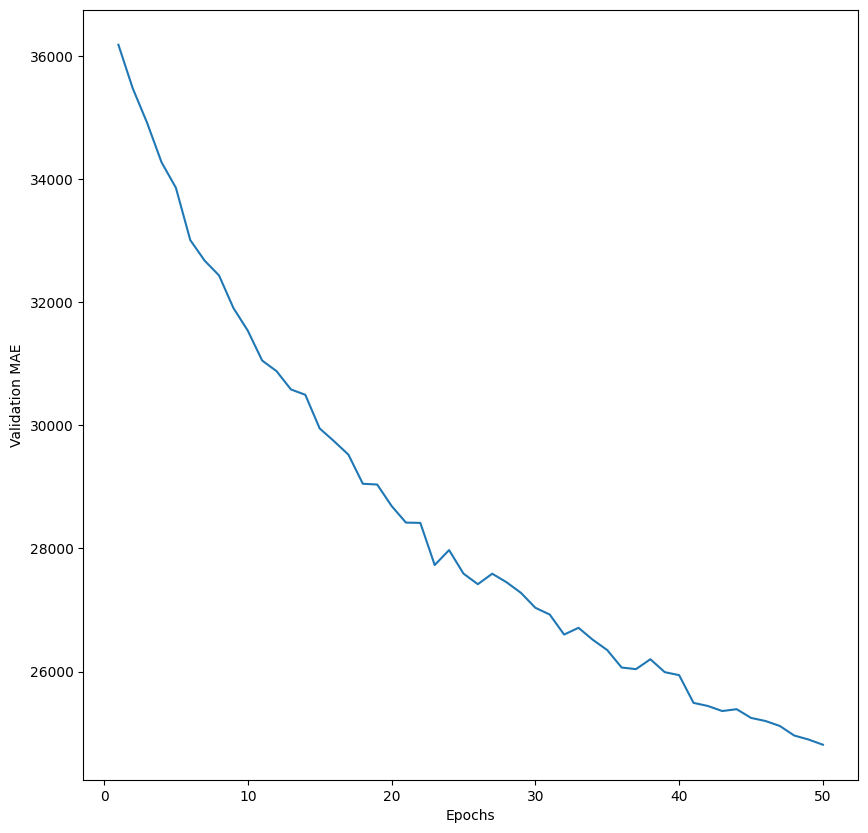

In [244]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.plot(range(1,len(all_mae_avg[20:])+1), all_mae_avg[20:])

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [245]:
#Promedio de scores y r2
average_neg_mse = np.mean(scores)
average_r2 = np.mean(r2)

print(f"Valor promedio de MAE Error Absoluto medio: {average_neg_mse}")
print(f"Valor promedio de r2: {average_r2}")

Valor promedio de MAE Error Absoluto medio: 24810.70703467205
Valor promedio de r2: 0.6926135219060584


In [246]:
scores

[22753.881759917665,
 24161.21954528443,
 28582.678845434133,
 24387.41925523952,
 22796.893268151198,
 27099.2842089259,
 23893.572359751506]

In [247]:
r2

[0.8300512829296129,
 0.7857150408224944,
 0.3891091685497653,
 0.5135289547347357,
 0.7876585182990017,
 0.7534235593749381,
 0.7888081286318601]